In [1]:
! pip install ultralytics roboflow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 25.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [2]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
import os
import numpy as np
from PIL import Image
from roboflow import Roboflow
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt
import time

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
    image = image.copy()
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)

    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image, 
                    label, 
                    (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None, max_width=800):
    image = image.copy()

    if labels == []:
        labels = {0: u'person', 1: u'bicycle', 2: u'car', 3: u'motorcycle', 4: u'airplane', 5: u'bus', 
                 6: u'train', 7: u'truck', 8: u'boat', 9: u'traffic light', 10: u'fire hydrant', 
                 11: u'stop sign', 12: u'parking meter', 13: u'bench', 14: u'bird', 15: u'cat', 
                 16: u'dog', 17: u'horse', 18: u'sheep', 19: u'cow', 20: u'elephant', 21: u'bear', 
                 22: u'zebra', 23: u'giraffe', 24: u'backpack', 25: u'umbrella', 26: u'handbag', 
                 27: u'tie', 28: u'suitcase', 29: u'frisbee', 30: u'skis', 31: u'snowboard', 
                 32: u'sports ball', 33: u'kite', 34: u'baseball bat', 35: u'baseball glove', 
                 36: u'skateboard', 37: u'surfboard', 38: u'tennis racket', 39: u'bottle', 
                 40: u'wine glass', 41: u'cup', 42: u'fork', 43: u'knife', 44: u'spoon', 45: u'bowl', 
                 46: u'banana', 47: u'apple', 48: u'sandwich', 49: u'orange', 50: u'broccoli', 
                 51: u'carrot', 52: u'hot dog', 53: u'pizza', 54: u'donut', 55: u'cake', 56: u'chair', 
                 57: u'couch', 58: u'potted plant', 59: u'bed', 60: u'dining table', 61: u'toilet', 
                 62: u'tv', 63: u'laptop', 64: u'mouse', 65: u'remote', 66: u'keyboard', 
                 67: u'cell phone', 68: u'microwave', 69: u'oven', 70: u'toaster', 71: u'sink', 
                 72: u'refrigerator', 73: u'book', 74: u'clock', 75: u'vase', 76: u'scissors', 
                 77: u'teddy bear', 78: u'hair drier', 79: u'toothbrush'}

    if colors == []:
        np.random.seed(42)
        colors = np.random.randint(0, 255, size=(len(labels), 3)).tolist()

    for box in boxes:
        box = box.cpu().numpy() if hasattr(box, 'cpu') else box
        if score:
            label = f"{labels[int(box[5])]} {round(100 * float(box[4]), 1)}%"
        else:
            label = labels[int(box[5])]

        if conf:
            if box[4] > conf:
                color = colors[int(box[5])]
                image = box_label(image, box, label, color)
        else:
            color = colors[int(box[5])]
            image = box_label(image, box, label, color)

    # Redimensionner l'image si elle est trop grande
    height, width, _ = image.shape
    if width > max_width:
        ratio = max_width / width
        new_height = int(height * ratio)
        image = cv2.resize(image, (max_width, new_height))

    # Convertir l'image de BGR en RGB pour Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Afficher l'image avec Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Désactive les axes
    plt.show()

    return image



In [4]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 135MB/s]


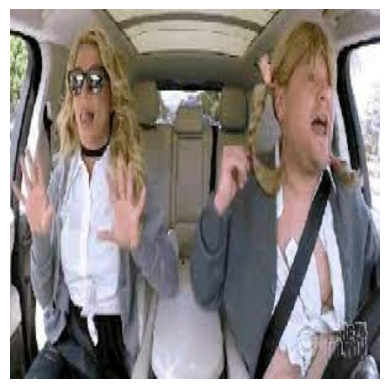

In [5]:
image = cv2.imread("/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train/images/-bvvfg-_jpg.rf.54143b49d3a2f56ab7b753c9e5849b2d.jpg")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')  # Désactive les axes
plt.show()


0: 640x640 1 person, 7.8ms
Speed: 9.3ms preprocess, 7.8ms inference, 266.9ms postprocess per image at shape (1, 3, 640, 640)


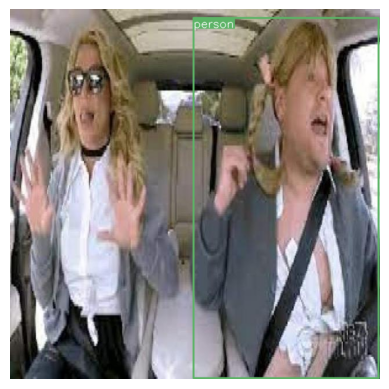

tensor([[3.1746e+02, 1.5484e+01, 6.3770e+02, 6.3824e+02, 3.5262e-01, 0.0000e+00]], device='cuda:0')

In [6]:
results = model.predict(image)
plot_bboxes(image, results[0].boxes.data, score=False)
results[0].boxes.data

In [7]:
# Labeling view
path = "/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train"
label_path = path + "/labels/"
image_path = path + "/images/"
name = "-bvvfg-_jpg.rf.54143b49d3a2f56ab7b753c9e5849b2d"

# Lire le fichier de label
with open(label_path + name + ".txt", 'r') as label_file:
    labels = label_file.readlines()

image = cv2.imread(image_path + name + ".jpg")
image = np.asarray(image)

# Récupérer les dimensions de l'image
h, w, _ = image.shape

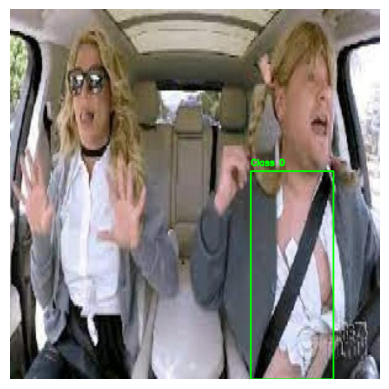

In [8]:
#Labeling view
path = "/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train"
label_path = path+"/labels/"
image_path = path+"/images/"
name = "-bvvfg-_jpg.rf.54143b49d3a2f56ab7b753c9e5849b2d"

# Lire le fichier de label
with open(label_path+name+".txt", 'r') as label_file:
    labels = label_file.readlines()

image = cv2.imread(image_path+name+".jpg")
image = np.asarray(image)

# Récupérer les dimensions de l'image
h, w, _ = image.shape

# Parcourir les labels et dessiner les bounding boxes
for line in labels:
    values = line.strip().split()
    
    class_id = int(values[0])  # ID de la classe
    x_center, y_center, box_width, box_height = map(float, values[1:])

    # Convertir YOLO format (x_center, y_center, width, height) en pixels
    x1 = int((x_center - box_width / 2) * w)
    y1 = int((y_center - box_height / 2) * h)
    x2 = int((x_center + box_width / 2) * w)
    y2 = int((y_center + box_height / 2) * h)

    # Dessiner le rectangle sur l'image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vert
    cv2.putText(image, f"Class {class_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Afficher l'image
#cv2.imshow("Image avec Labels", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off') 
plt.show()

In [9]:
#création du fichier yaml
import yaml

data_config = {
    "train": "/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train",
    "val": "/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/valid",
    "test": "/kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/test",
    "nc": 1,
    "names": {0: "ceinture"}
}

# Sauvegarde dans un fichier YAML
yaml_file = "ceinture.yaml"
with open(yaml_file, "w", encoding="utf-8") as file:
    yaml.dump(data_config, file, default_flow_style=False, allow_unicode=True)

print(f"Fichier YAML créé : {yaml_file}")


Fichier YAML créé : ceinture.yaml


In [10]:
start_time = time.time()
results = model.train(
    data="/kaggle/working/ceinture.yaml",  # Le fichier YAML
    epochs=50,  # Nombre d'époques, 50 est une bonne valeur de départ
    imgsz=640,  # Taille de l'image, idéale pour la plupart des modèles, tu peux augmenter à 1024 si tu as plus de mémoire GPU
    patience=5,  # Arrêt précoce basé sur la patience
    plots=True,  # Affichage des graphiques (utile pour le suivi de l'entraînement)
    augment=False, #True,  # Activation de la data augmentation pour améliorer la généralisation
    device='cuda'  # Utilisation du GPU
)

total_time = time.time() - start_time
print(f"Temps d'entraînement total: {total_time // 60:.0f} minutes et {total_time % 60:.0f} secondes")

#avaec data augmentation Temps d'entraînement total: 30 minutes et 41 secondes
# sans data augmentation Temps d'entraînement total: 30 minutes et 35 secondes


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/ceinture.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train/labels... 4468 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4468/4468 [00:13<00:00, 322.92it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 73, len(boxes) = 5131. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/valid/labels... 985 images, 1 backgrounds, 0 corrupt: 100%|██████████| 985/985 [00:02<00:00, 332.36it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/valid is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 1131. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.4G      2.385      2.908      2.367          9        640: 100%|██████████| 280/280 [00:54<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.41it/s]


                   all        985       1131      0.391      0.363      0.316      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.38G      1.891      2.221      1.975          3        640: 100%|██████████| 280/280 [00:51<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.67it/s]


                   all        985       1131       0.44      0.409       0.37      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.37G       1.85      2.073      1.924         13        640: 100%|██████████| 280/280 [00:51<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.81it/s]


                   all        985       1131      0.474      0.416      0.359      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.37G      1.759      1.939      1.847          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.80it/s]

                   all        985       1131      0.509      0.453      0.434      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.37G      1.731      1.897      1.839          8        640: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.79it/s]


                   all        985       1131      0.603      0.533      0.575      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G      1.698      1.841      1.796          8        640: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]


                   all        985       1131       0.59      0.529      0.581      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.37G      1.676      1.785      1.776         11        640: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.76it/s]

                   all        985       1131       0.54      0.574      0.509      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.37G      1.653      1.726      1.744          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.77it/s]

                   all        985       1131      0.604      0.561      0.591      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G      1.605      1.677       1.71          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.79it/s]

                   all        985       1131      0.644      0.559        0.6      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G      1.597      1.632      1.704          9        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.50it/s]

                   all        985       1131       0.64       0.59      0.669      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.37G      1.583      1.596      1.692          5        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.81it/s]

                   all        985       1131      0.706      0.599      0.653      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G      1.568      1.553      1.668         13        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.80it/s]


                   all        985       1131      0.693      0.622      0.686      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G      1.541      1.535      1.635          5        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.76it/s]

                   all        985       1131      0.667      0.586      0.637       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.523      1.498      1.628          6        640: 100%|██████████| 280/280 [00:50<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]

                   all        985       1131      0.668      0.626      0.627      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G      1.516      1.474      1.628          6        640: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.71it/s]

                   all        985       1131      0.707      0.595      0.682       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.37G      1.496      1.451      1.619         10        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.79it/s]

                   all        985       1131      0.727      0.676      0.719      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G      1.489      1.429      1.601         12        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.72it/s]

                   all        985       1131      0.727       0.67      0.728      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G      1.467      1.389      1.595          6        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.59it/s]

                   all        985       1131      0.749      0.671      0.733      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.37G      1.482      1.394      1.595          9        640: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]

                   all        985       1131      0.705      0.681      0.736       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.37G      1.449      1.369       1.58         14        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.82it/s]

                   all        985       1131      0.766      0.733      0.772      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G      1.445      1.359      1.576          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.75it/s]

                   all        985       1131      0.767      0.704      0.777      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G      1.434      1.325      1.555         10        640: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.63it/s]

                   all        985       1131      0.722      0.721      0.762      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.37G      1.424      1.289      1.546          8        640: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.81it/s]

                   all        985       1131      0.817      0.704       0.78      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.37G      1.411      1.271      1.536         10        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.90it/s]

                   all        985       1131      0.772      0.717      0.778      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G      1.394      1.249      1.527          9        640: 100%|██████████| 280/280 [00:50<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.75it/s]

                   all        985       1131      0.781      0.687      0.774      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G      1.382      1.223      1.514          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.79it/s]

                   all        985       1131      0.782      0.749      0.799      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G      1.376       1.21      1.506         11        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.76it/s]

                   all        985       1131      0.775      0.737      0.796      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.37G      1.362      1.204      1.492          7        640: 100%|██████████| 280/280 [00:50<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.78it/s]

                   all        985       1131      0.749      0.752      0.775       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G       1.35      1.178      1.483          8        640: 100%|██████████| 280/280 [00:50<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.74it/s]

                   all        985       1131       0.77       0.76      0.801      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.37G      1.334      1.171      1.473          8        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.82it/s]

                   all        985       1131      0.774      0.737      0.786      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.37G      1.347      1.156       1.48         11        640: 100%|██████████| 280/280 [00:50<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.86it/s]

                   all        985       1131      0.756       0.73      0.767      0.358


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 26, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

31 epochs completed in 0.491 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


                   all        985       1131      0.781       0.75      0.799      0.397


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train
Temps d'entraînement total: 30 minutes et 35 secondes


In [11]:
#Télécharger le model
!zip -r yolo_trained_false.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/val_batch1_labels.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/train/weights/best.pt (deflated 9%)
  adding: kaggle/working/runs/detect/train/weights/last.pt (deflated 9%)
  adding: kaggle/working/runs/detect/train/labels.jpg (deflated 20%)
  adding: kaggle/working/runs/detect/train/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/train/train_batch1.jpg (deflated 2%)
  adding: kaggle/working/runs/detect/train/events.out.tfevents.1739744744.4a1bb394e342.31.0 (deflated 91%)
  adding: kaggle/working/runs/detect/train/P_curve.png (deflated 17%)
  adding: kaggle/working/runs/detect/train/PR_curve.png (deflated 18%)
  adding: kaggle/working/runs/detect/train/F1_curve.png 

In [12]:
metrics = model.val(
    data="/kaggle/working/ceinture.yaml",  # Le fichier YAML
    batch=16,  # Taille du batch
    conf=0.5,  # Seuil de confiance
    iou=0.6) 

metrics

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/valid/labels... 985 images, 1 backgrounds, 0 corrupt: 100%|██████████| 985/985 [00:00<00:00, 1004.12it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-ceinture/seatbelt.v11i.yolov8/valid is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 1131. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:06<00:00, 10.13it/s]


                   all        985       1131       0.92       0.51       0.71      0.412


invalid value encountered in less
invalid value encountered in less


Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78615f9b6e30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [13]:
print(f"Précision : {metrics.box.map:.4f}")
# print(f"Précision moyenne pondérée (mAP50-95) : {metrics.box.map50_95:.4f}")

# Accéder à la précision, le rappel et le score F1 par classe
print(f"Précision (Precision par classe Texte) : {sum(metrics.box.p) / len(metrics.box.p):.4f}")
print(f"Rappel (Recall par classe Texte) : {sum(metrics.box.r) / len(metrics.box.r):.4f}")
print(f"Score F1 : {sum(metrics.box.f1) / len(metrics.box.f1):.4f}")

Précision : 0.4121
Précision (Precision par classe Texte) : 0.9203
Rappel (Recall par classe Texte) : 0.5102
Score F1 : 0.6564
